<font size='6'>Variational Inference - Online Learning</font>

<font size='5'>Purpose</font>

One of the difficulties in dealing with financial time series data is that there are many time-varying parameters, and the distributions are not stationary. Clustering approaches may be used to discover where these parameters are varying, and give us some idea of the overall stability/instability of those time-varying parameters.

If models are built with any assumptions about the parameters of the data, and those parameters shift, then the model assumptions are invalidated and that model will fail. Mixture models based on EM (expectation-maximization) partition the data into states where the covariance matrix and mean of the parameters within each state differ significantly. A nice feature of the Dirichlet process mixture model is that is it both a clustering and generative model from which we can generate new samples based on the fitted posterior distribution.

<font size='5'>Method</font>

Using variational inference applied to time series data, the algorithm non-parametrically chooses a likely number of clusters (latent states) each with distinct <b>mean and covariance</b> parameters allowing computation of a likelihood function for the 3-dimensional point at any time step. The model optimizes the parameters of the clusters to maximize the likelihood of those parameters given the data. 

In order to define what it means to be a good approximation the Kullback-Leibler divergence (KL divergence) is a non-symmetric measure of the difference between two probability distributions 𝑃 and 𝑄, the true posterior and the approximating variational distribution (mean field variational inference - see paper https://www.cs.princeton.edu/courses/archive/fall11/cos597C/lectures/variational-inference-i.pdf). 

This comes from information theory -- entropy is the average amount of information or "surprise" in the divergence between the distributions. 

$$\large KL(q||p)=E_q\Bigg[\ log\  \frac{q(Z)}{p(Z\  |\ x)}\ \Bigg]$$

In the mean-field approximation, we also assume that the latent states will be partitioned so that each partition is independent. Using KL divergence, we can derive mutually dependent equations (one for each partition) that defines 𝑄 to approximate the posterior distribution. This is done for ease of computation for the iterative approach (expectation-maximization). Maximizing the ELBO log likelihood is equivalent to minimizing the KL divergence between the approximator 𝑄 and the true posterior 𝑃. This is the ELBO constructed with Jensens inequality. 

$$\large log\:p(x | θ) ≥ E_q [log\:p(W, x | θ)] − E_q [log\:q_ν(W)]$$

Borrowing from Physics, in a system with many components that interact, those system interactions are replaced with a single average interaction (a "mean field"). The states' mean/covariances factorize, 

$$\large q(\boldsymbol{\theta}) \approx \prod_{i=1}^n q(\theta_i)$$

$$\large q(\boldsymbol{\mu}, \boldsymbol{\Sigma}) \approx \prod_{i=1}^n q(\mu_i) q(\Sigma_i)$$

This variant of the notebook will be doing online learning with warm_start=True. 

In [24]:
import warnings
warnings.filterwarnings('ignore')

import scipy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

from scipy.special import softmax
from scipy.stats import entropy

Testing a small universe of the 10Y Treasury, a Commodity ETF, and Tech ETF. The goal will be time series clustering using variational inference. 

Set num_components to a very high number so the data is fit in a non-parametric way where we need not know the number of clusters in advance. 

In [25]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 10

Create the subset of assets.

In [26]:
m6 = pd.read_csv('./data/assets_m6_2022.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

<font size="5">Lebesgue Integral, Auto-Correlation Decay Plots, & Online Learner</font>

Formatting the training data. There is 5% of data held for training and the remaining 95% of the data is learned is an online, walk-forward fashion where the model updates itself if the log likelihood of the observed data deviates too far.

Z-scored measurements of the log price for each asset based on a rolling window. This is tracking a rolling integral within a bounded moving window and how much the area under the curve bounded between 'a' and 'b' compares to the value at the most recent time point. Per the mean value theorem the integral and mean are identical here. 

$$\huge z = \frac{x - \int_a^b x(t) dt}{\sigma}$$

$$\huge z = \frac{x - \mu}{\sigma}$$

There are regions where the current log return is either above or below its running average and this formatting of the data preserves long memory based on looking at the auto-correlation decay plots. <b>It is important that the running average never takes into account future data which would introduce lookahead bias, so a rolling metric based on the list comprehension is used.</b> 

The ACF function is defined as follows, 

$$ \huge \operatorname{ACF}(\tau) = \frac{\sum_{t=1}^{n-\tau} (x_t - \bar{x})(x_{t+\tau} - \bar{x})}{\sum_{t=1}^n (x_t - \bar{x})^2} $$

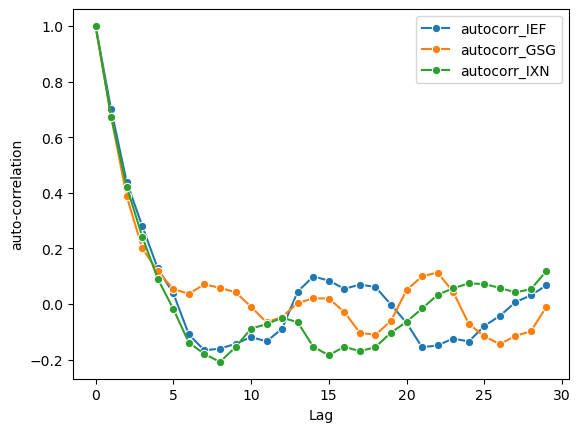

In [27]:
import scipy.stats as stats
m6_subset1 = m6_assets.copy()

# Window length 25 days
wlen = 25

# First convert to log price 
m6_subset1 = m6_subset1.apply(np.log)

# Clean data
m6_subset1 = m6_subset1.dropna().reset_index().drop(columns='index')

# Apply z-score in a rolling way that does not create lookahead bias 
rolling_zscore = lambda serie: [ stats.zscore(serie[x-wlen:x]).values[-1] for x in range(wlen, len(serie) + 1) ]

m6_subset = pd.DataFrame()
m6_subset['IEF'] = rolling_zscore(m6_subset1['IEF'])
m6_subset['GSG'] = rolling_zscore(m6_subset1['GSG'])
m6_subset['IXN'] = rolling_zscore(m6_subset1['IXN'])

# View Auto Correlation
decay_func = lambda S, _range: [S.apply(abs).autocorr(lag=Lag) for Lag in _range]
sns.lineplot(data=decay_func(m6_subset['IEF'], range(0, 30)), label='autocorr_IEF', marker='o') 
sns.lineplot(data=decay_func(m6_subset['GSG'], range(0, 30)), label='autocorr_GSG', marker='o')
sns.lineplot(data=decay_func(m6_subset['IXN'], range(0, 30)), label='autocorr_IXN', marker='o')
plt.xlabel('Lag')
plt.ylabel('auto-correlation')
plt.show()

Instantiate a non-parametric clustering model using the dirichlet process. Then, sample len(m6_subset) separate individual draws from the variational model. This sampling should draw certain states in proportion to their weight in the posterior distribution. 

In [28]:
# Instantiate mixture model 
dpgmm_model = mix.BayesianGaussianMixture(
    n_components=num_components, 
    weight_concentration_prior_type='dirichlet_process',
    n_init=15,
    max_iter=3000000,
    warm_start=True)

re-train 15
re-train 45
re-train 72
re-train 88


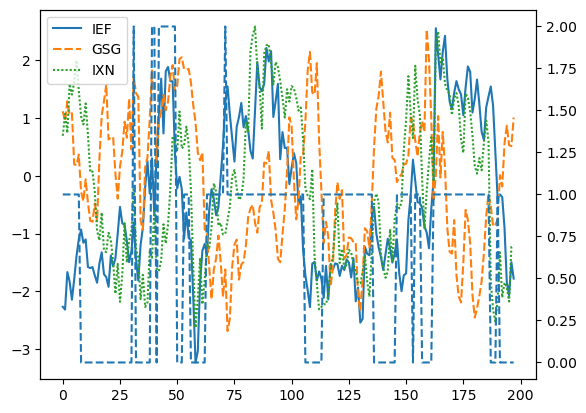

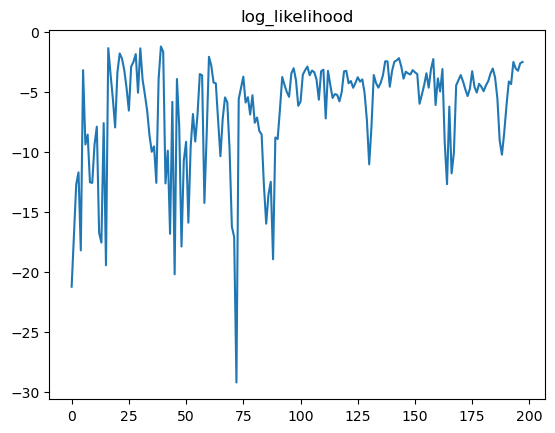

In [29]:
# Train test split 
from sklearn.model_selection import train_test_split
m6_train, m6_testdata = train_test_split(m6_subset, train_size=0.05, test_size=0.95, shuffle=False)

# Fit the model
m6_train['state'] = dpgmm_model.fit_predict(m6_train)

# Predict the test data 
m6_test = m6_testdata.copy()

# Array of likelihoods
likelihood_deltas = []

# State counts of each hidden Markov state 
state_counts = np.zeros(num_components)
for M in m6_train['state']:
  state_counts[M] += 1 

# States
states = [] 

# Iterate over test data
for i, point in m6_test.iterrows():
    
    # Predict state of current point
    state = dpgmm_model.predict([point[['IEF','GSG','IXN']]])[0] 

    # Compute log likelihood
    log_likelihood = scipy.stats.multivariate_normal.logpdf(
        point[['IEF','GSG','IXN']],
        mean=dpgmm_model.means_[state], cov=dpgmm_model.covariances_[state]
    )
      
    # Compare log likelihood with percentile
    if len(likelihood_deltas) > 0 and log_likelihood < np.percentile(likelihood_deltas, 5):
        print(f're-train {i - len(m6_train)}')
        
        # Retrain the model with new data
        m6_retrain = m6_train.copy().append(m6_test.loc[:i])  
        m6_retrain['state'] = dpgmm_model.fit_predict(m6_retrain[['IEF','GSG','IXN']])
        
        # Add state 
        states.append(m6_retrain['state'].values[-1])
    else: 
        states.append(state)
    
    # Append
    likelihood_deltas.append(log_likelihood)

fig,ax=plt.subplots()
axx=ax.twinx()
sns.lineplot(data=states, linestyle='--', ax=axx)
sns.lineplot(data=m6_subset.loc[len(m6_train):].reset_index().drop(columns=['index']), ax=ax)
plt.show()

sns.lineplot(data=likelihood_deltas)
plt.title('log_likelihood')
plt.show()